In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_percentage_error
from deap import base, creator, tools, algorithms

In [2]:
data = pd.read_csv('DATA_PROVINSI.csv')

df = pd.DataFrame(data)

# Normalisasi MinMax
scaler = MinMaxScaler()
df['jumlah_kecelakaan'] = scaler.fit_transform(df[['jumlah_kecelakaan']])

# Menambahkan kolom lag (pergeseran)
df['jumlah_kecelakaan_lag'] = df['jumlah_kecelakaan'].shift(1)
df = df.dropna() # Menghapus baris dengan nilai NaN

In [3]:
# Memisahkan data latih dan data uji sesuai rasio (0.8 untuk 80:20)
train_size = int(0.7 * len(df))
train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:]

# Memisahkan fitur dan target untuk data latih
X_train = train_data['jumlah_kecelakaan_lag'].values.reshape(-1, 1)
y_train = train_data['jumlah_kecelakaan'].values

# Memisahkan fitur dan target untuk data uji
X_test = test_data['jumlah_kecelakaan_lag'].values.reshape(-1, 1)
y_test = test_data['jumlah_kecelakaan'].values

In [4]:
# Define evaluation function
def evaluate(individual):
    C, epsilon, gamma = individual
    if C <= 0 or epsilon <= 0 or gamma <= 0:
        return float('inf'),
    svr = SVR(C=C, epsilon=epsilon, gamma=gamma)
    svr.fit(X_train, y_train)
    y_pred = svr.predict(X_test)
    mape = mean_absolute_percentage_error(y_test, y_pred) * 100
    return mape,
    
# Setup DEAP framework
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()

# Parameter ranges
C_range = (0.0001, 50)
epsilon_range = (1e-07, 5)
gamma_range = (1e-07, 5)

def create_individual():
    C = random.uniform(*C_range)
    epsilon = random.uniform(*epsilon_range)
    gamma = random.uniform(*gamma_range)
    return creator.Individual([C, epsilon, gamma])
    
toolbox.register("individual", create_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("mate", tools.cxUniform, indpb=0.5)  # Menggunakan crossover uniform 
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2) # Menggunakan mutasi gaussian
toolbox.register("select", tools.selTournament, tournsize=3) # Menggunakan seleksi turnamen
toolbox.register("evaluate", evaluate)

generasi 10: 24.0519
generasi 20: 24.0500
generasi 30: 24.1675
generasi 40: 24.0376
generasi 50: 24.0812
generasi 60: 24.0382
generasi 70: 24.1570
generasi 80: 24.1969
generasi 90: 24.0360
generasi 100: 24.0326

Jumlah Generasi optimal: 100
MAPE terbaik: 24.0326
[26.833701393351287, 0.43765152822476755, 0.002829894706261783]


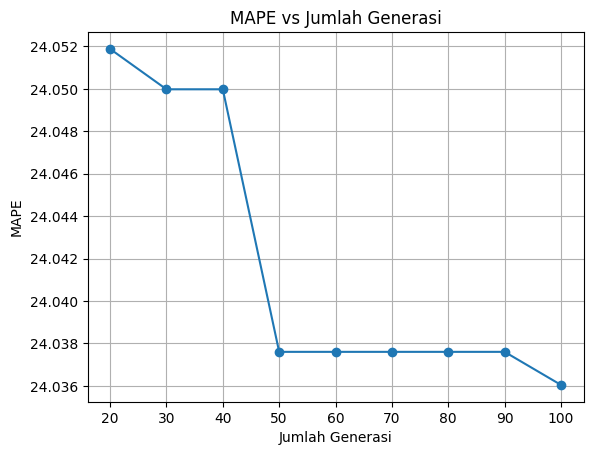

In [5]:
def main():
    population_size = 240
    num_generations_list = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    crossover_rate = 0.5
    mutation_rate = 0.2
    
    best_num_generations = None
    best_mape = float('inf')
    
    results = []

    for num_generations in num_generations_list:
        population = toolbox.population(n=population_size)

        for generation in range(num_generations):
            offspring = algorithms.varAnd(population, toolbox, cxpb=crossover_rate, mutpb=mutation_rate)
            for ind in offspring:
                ind[0] = max(min(ind[0], C_range[1]), C_range[0])
                ind[1] = max(min(ind[1], epsilon_range[1]), epsilon_range[0])
                ind[2] = max(min(ind[2], gamma_range[1]), gamma_range[0])
            
            fits = toolbox.map(toolbox.evaluate, offspring)
            for fit, ind in zip(fits, offspring):
                ind.fitness.values = fit

            population = toolbox.select(offspring, k=len(population))

        best_individual = tools.selBest(population, k=1)[0]
        mape = best_individual.fitness.values[0]
        
        results.append((num_generations, best_mape))
        print(f"generasi {num_generations}: {mape:.4f}")

        if mape < best_mape:
            best_mape = mape
            best_num_generations = num_generations

    print(f"\nJumlah Generasi optimal: {best_num_generations}")
    print(f"MAPE terbaik: {best_mape:.4f}")
    print(best_individual)

    # Plot hasil setiap iterasi dan nilai MAPE-nya
    num_generations, best_num_generations_mape = zip(*results)
    plt.plot(num_generations, best_num_generations_mape, marker='o')
    plt.xlabel("Jumlah Generasi")
    plt.ylabel("MAPE")
    plt.title("MAPE vs Jumlah Generasi")
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    main()